Trying to use [fhirtordf](https://github.com/BD2KOnFHIR/fhirtordf) for parsing the FHIR bundle from [synthea](https://synthetichealth.github.io/synthea/) to RDF, which can then be transformed to knowledge graph for use in RAG or other operations.

In [ ]:
%pip install rdflib networkx netgraph fhirtordf --user

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for dirlistproc: filename=dirlistproc-1.4.5-py3-none-any.whl size=6443 sha256=efecb1093d65452dd9cbd2938f8288817c9b0c5840fc376bce96fc87b176214c
  Stored in directory: c:\users\peter\appdata\local\pip\cache\wheels\02\5a\6f\688c77c1c42d1af11d9671e71b5cf1b4a1500551d21f4a86c5
Successfully built dirlistproc

   ------------- -------------------------- 2/6 [isodate]
  Attempting uninstall: rdflib
   ------------- -------------------------- 2/6 [isodate]
    Found existing installation: rdflib 7.2.1
   ------------- -------------------------- 2/6 [isodate]
   -------------------- ------------------- 3/6 [rdflib]
    Uninstalling rdflib-7.2.1:
   --------

In [3]:
from rdflib import Graph, URIRef, BNode, OWL, RDF, Literal, Namespace
from fhirtordf.loaders.fhirjsonloader import fhir_json_to_rdf
from fhirtordf.fhir.fhirmetavoc import FHIRMetaVoc
import networkx as nx
import json

In [36]:
g = fhir_json_to_rdf(
        json_fname='C:/Users/Peter/Documents/GitHub/daily-coding/fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json',
        # base_uri='https://peterdobbs77.github.io/fhir/',
        metavoc = FHIRMetaVoc(mv_file_loc="http://build.fhir.org/fhir.ttl")
    )

In [37]:
print(g.serialize(format='turtle').decode('utf-8'))

@prefix fhir: <http://hl7.org/fhir/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

<http://hl7.org/fhir/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CareTeam/82697300-ce70-49e9-9012-79a33a776b59> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CareTeam/82697300-ce70-49e9-9012-79a33a776b59.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CareTeam/a542026f-5591-4bfc-903e-6216794179ce> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CareTeam/a542026f-5591-4bfc-903e-62167941

In [55]:
print(len(g))

1276


Something is off in the way that the references are being created. I think `fhirtordf` is struggling to establish references based on the structure of the synthea-generated data.

Instead let's try to do the conversion manually...

In [24]:
from fhir_to_rdf import FhirGraph   # local dev work by Peter N. Dobbs
import json

with open('../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'r') as f:
    fhir_bundle = json.load(f)

fhir_graph = FhirGraph(fhir_bundle)
result_graph = fhir_graph.generate()

print(result_graph.serialize(format='turtle').decode('utf-8'))

@prefix fhir: <http://hl7.org/fhir/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/Condition/0472ed1c-4efa-4c86-bcf1-5eea6bda2432> a fhir:Condition ;
    fhir:clinicalStatus "{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-clinical', 'code': 'active'}]}" ;
    fhir:code "{'coding': [{'system': 'http://snomed.info/sct', 'code': '429007001', 'display': 'History of cardiac arrest (situation)'}], 'text': 'History of cardiac arrest (situation)'}" ;
    fhir:encounter <http://example.org/Encounter/f78d73fc-9f9b-46d5-93aa-f5db86ba914c> ;
    fhir:nodeRole fhir:treeRoot ;
    fhir:onsetDateTime "1965-11-15T06:22:41-05:00" ;
    fhir:recordedDate "1965-11-15T06:22:41-05:00" ;
    fhir:resourceType "Condition" ;
    fhir:subject <http://example.org/Patient/5cbc121b-cd71-4428-b8b7-31e53eba8184> ;
    fhir:verificationStatus "{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-ver-status', 'code': 'confirmed'}]}" .

<http://ex

In [25]:
for s in result_graph.subjects():
    if isinstance(s, BNode):
        print("Blank node:", s)
        for subj, pred in result_graph.subject_predicates(object=s):
            print(f"{subj} -- {pred} -> [blank node]")
        for pred, obj in result_graph.predicate_objects(subject=s):
            print(f"[blank node] -- {pred} -> {obj}")

C:\Users\Peter\AppData\Local\Temp\ipykernel_13072\4180478302.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


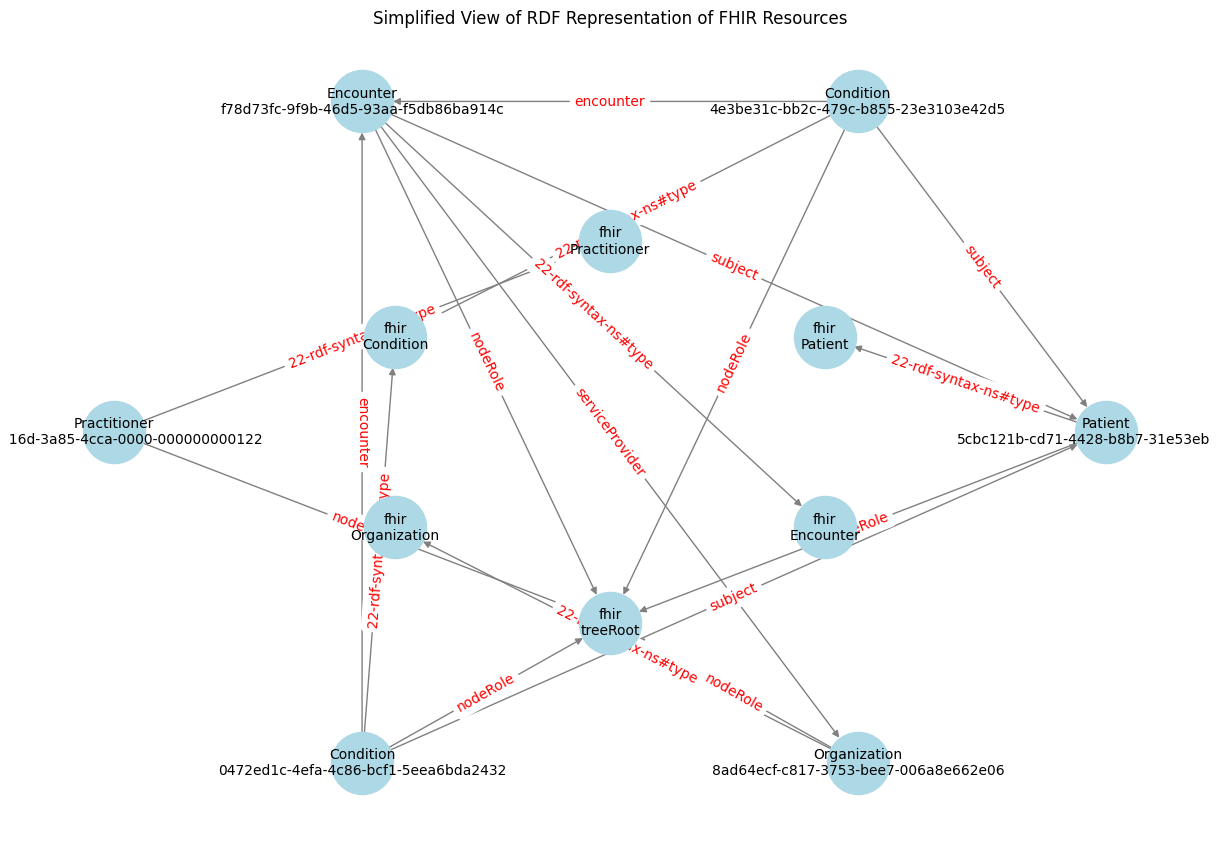

In [26]:
from rdflib import URIRef
import networkx as nx
import matplotlib.pyplot as plt

FHIR = Namespace("http://hl7.org/fhir/")

def pretty_view_rdf_graph(g: Graph, format="turtle"):
    '''Visualize simplified view of the RDF graph, 
        just showing connections between FHIR Resources
    :param g: `rdflib.Graph`'''
    # Create NetworkX graph
    nx_graph = nx.DiGraph()

    for subj, pred, obj in g:
        if not isinstance(obj, URIRef):
            continue
        # Convert nodes to readable strings
        subj_str = str(subj).split('/')[-2] + '\n' + str(subj).split('/')[-1]
        pred_str = str(pred).split('/')[-1]
        obj_str = str(obj).split('/')[-2] + '\n' + str(obj).split('/')[-1]

        # Add edge with predicate label
        nx_graph.add_edge(subj_str, obj_str, label=pred_str)
    
    # Draw graph
    # pos = nx.arf_layout(nx_graph, seed=42) # ARF is better than spring
    pos = nx.shell_layout(nx_graph, 
                            nlist=[[x for x in nx_graph.nodes() if 'fhir' in x],
                                    [x for x in nx_graph.nodes() if 'fhir' not in x]])
    edge_labels = nx.get_edge_attributes(nx_graph, 'label')

    plt.figure(figsize=(12, 8))
    nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Simplified View of RDF Representation of FHIR Resources")
    plt.tight_layout()
    plt.show()

pretty_view_rdf_graph(result_graph)

Okay, this is all coming together! 🎉

Notice, though, that the Practitioner is missing linkages to other resources! (TODO: expand on code to support linking Practitioner to appropriate references)

Let's try loading more resources and visualizing from there!

673


C:\Users\Peter\AppData\Local\Temp\ipykernel_13072\4180478302.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


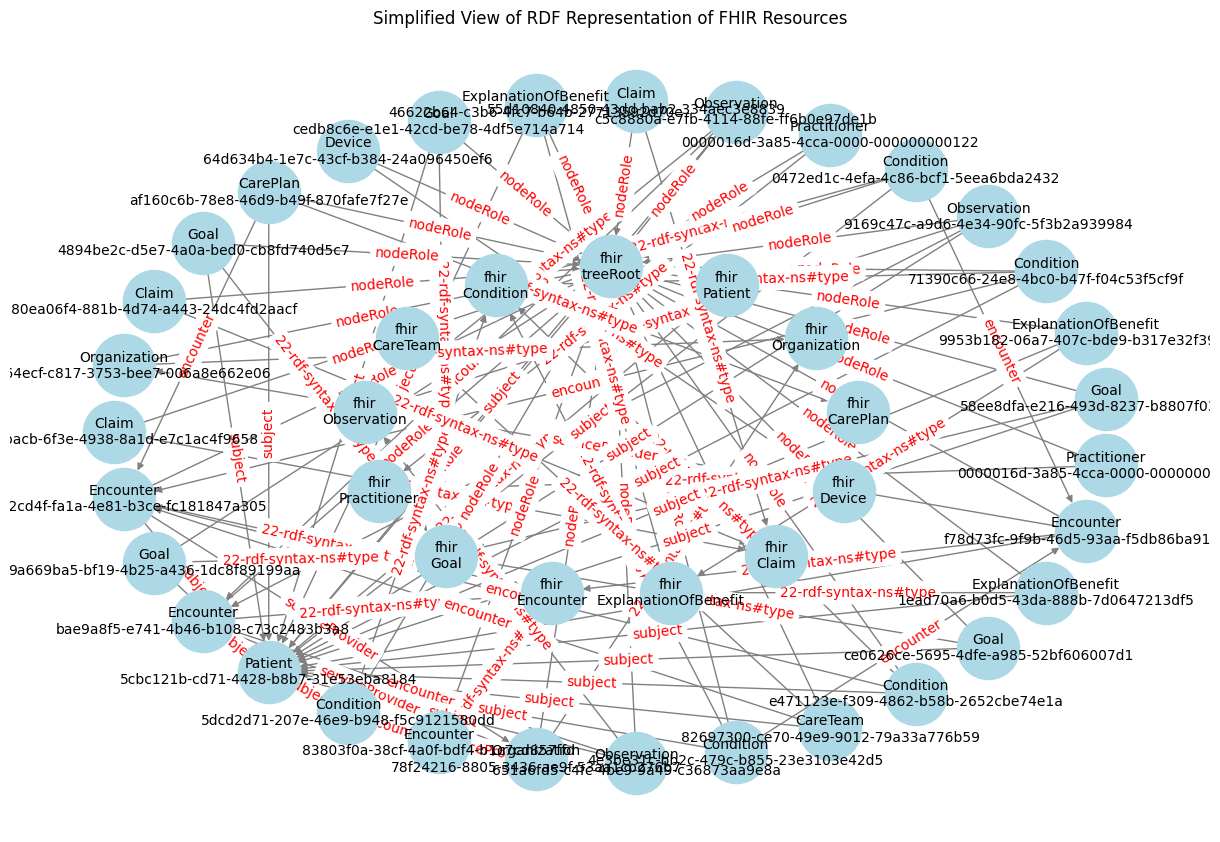

In [27]:
with open('../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'r') as f:
    fhir_bundle = json.load(f)

bigger_fhir_graph = FhirGraph(fhir_bundle)
bigger_result_graph = fhir_graph.generate(limit=30)

print(len(bigger_result_graph))

pretty_view_rdf_graph(bigger_result_graph)

# Start from the source

FHIR publishes a Turtle file for defining the structure of FHIR resources. Let's try that!

Build version: [http://build.fhir.org/fhir.ttl](http://build.fhir.org/fhir.ttl)

In [2]:
# 
from rdflib import Graph

fhir_kg = Graph()
fhir_kg.parse('http://build.fhir.org/fhir.ttl')
print(len(fhir_kg))

C:\Users\Peter\AppData\Roaming\Python\Python312\site-packages\rdflib\plugin.py:111: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points


90061


In [3]:
print(fhir_kg.serialize(format='turtle').decode('utf-8'))

@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix fhir: <http://hl7.org/fhir/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix w5: <http://hl7.org/fhir/w5#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

fhir:Account a owl:Class ;
    rdfs:label "Account" ;
    fhir:modifierExtensionClass fhir:_Account ;
    rdfs:comment "A financial tool for tracking value accrued for a particular purpose.  In the healthcare field, used to track charges for a patient, cost centers, etc." ;
    rdfs:subClassOf [ a owl:Restriction ;
            owl:allValuesFrom fhir:instant ;
            owl:onProperty fhir:calculatedAt ],
        [ a owl:Restriction ;
            owl:allValuesFrom fhir:AccountDiagnosisComponent ;
            owl:onProperty fhir:diagnosis ],
        [ a owl:Restriction ;
            owl:maxCardinality 1 ;
            owl:onProperty fhir:billingSta

In [ ]:
patient_connections_query = """
PREFIX fhir: <http://hl7.org/fhir/>

SELECT DISTINCT ?resourceType ?encounterDetails
{
    ?resource a fhir:Resource .
    ?resource fhir:
    ?encounter fhir:subject ?patient .
    ?patient a fhir:Patient .
    ?patient fhir:name ?patientName .
}
"""